In [32]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
from ipywidgets import interact
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score


In [33]:
NUM_SPLITS = 5
SPLIT_IDS = list(range(0, NUM_SPLITS))
MODELS_DIR = '../data/evaluation/labelled-bootstrap/models/'

In [34]:
def plot_roc_curve(true_values, predictions, ax=None, title='ROC', label='ROC', lw=1, figsize=(6, 5), **kwargs):
    fpr, tpr, _ = roc_curve(true_values, predictions)
    roc_auc = auc(fpr, tpr)
    label_auc = label + ': {:.3f} AUC'.format(roc_auc)
    print(label_auc)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
    ax.plot(fpr, tpr, lw=lw, label=label_auc, **kwargs)
    ax.set_title(title)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend(loc='lower right')
    return ax

def plot_precision_recall_curve(true_values, predictions, ax=None, title='Precision-Recall', label='PR', lw=1, **kwargs):
    precision, recall, _ = precision_recall_curve(true_values, predictions)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    avg_precision = average_precision_score(true_values, predictions)
    ax.step(recall, precision, where='post', label=label + ': {:.3f} AP'.format(avg_precision), **kwargs)

    ax.set_title(title)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.legend(loc='upper right')
    return ax

In [35]:
def get_auc(true_values, predictions):
    fpr, tpr, _ = roc_curve(true_values, predictions)
    return auc(fpr, tpr)

def get_model_split_num_epochs(model_name, split):
    epochs = None
    with open(os.path.join(MODELS_DIR, model_name, 'model{}.out'.format(split))) as f:
        for line in f.readlines():
            if line.startswith('Epoch ') and '/' in line:
                epochs = int(line.replace('Epoch ', '').split('/')[0])
    return epochs

def get_model_split_prediction(model_name, split, method='validation'):
    return pd.read_csv(os.path.join(MODELS_DIR, model_name, '{}{}.csv'.format(method, split)))

def get_model_split_auc(model_name, split, method='validation'):
    predictions = get_model_split_prediction(model_name, split, method)
    return get_auc(predictions['in_cluster'], predictions['prediction'])

def get_model_summary(architecture, features, pfamdim, pfamiter, posweight, negset, classbalancing, split, learning_rate):
    if posweight == '1':
        posweightlabel = 1
    elif posweight == 'weighted':
        posweightlabel = 16.415 if classbalancing == '' else ('3.376' if classbalancing == '-classbalanced' else 'xxx')
    else:
        raise ValueError()
        
    if learning_rate == 0.001:
        learning_rate_label = '-0.001lr'
    elif learning_rate == 0.0001:
        learning_rate_label = ''
    else:
        raise ValueError()
    name = '{}{}{}-{}pfamdim-{}pfamiter-{}posweight-{}{}'.format(features, architecture, learning_rate_label, pfamdim, pfamiter, posweightlabel, negset, classbalancing)
    epochs = get_model_split_num_epochs(name, split=split)
    val_auc = get_model_split_auc(name, split=split, method='validation')
    test_auc = get_model_split_auc(name, split=split, method='test')
    return {
        'name': name,
        'classbalancing': classbalancing,
        'architecture': architecture,
        'features': features,
        'learning_rate': learning_rate,
        'pfamdim': pfamdim,
        'pfamiter': pfamiter,
        'negset': negset,
        'posweight': posweight,
        'split': split,
        'epochs': epochs,
        'val_auc': val_auc,
        'test_auc': test_auc
    }

## Test split contig overview

Mean: 7.777777777777778, Variance: 1.6944444444444444


split,0,1,2,3,4,5,6,7,8,9
genome_id,,,,,,,,,,
Kutzneria_sp_744,1,0,0,1,1,1,1,1,1,0
Micro_carb_varATCC39149,1,1,0,1,1,1,1,1,0,1
Micromonospora_M42_V1,1,1,1,1,0,0,0,1,1,1
S.ghanaensis_ATCC14672_V1,1,1,1,1,1,1,1,1,1,1
StrAlb_J1074_V3,1,1,1,1,0,1,0,0,1,1
Strept_hygr_ATCC53653,0,0,1,1,1,0,1,1,1,1
Strept_priATCC25486_V1,1,1,1,0,1,1,1,1,1,1
Strept_sp_AA4,1,1,1,0,1,1,1,0,0,0
Strept_sp_C,0,1,1,1,1,1,1,1,1,1


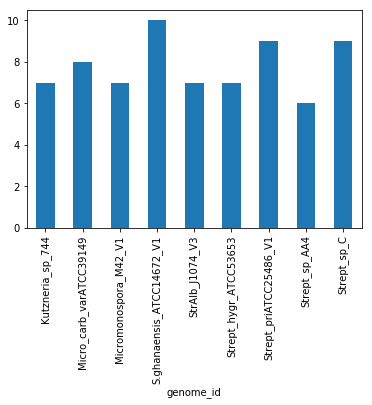

In [68]:
meta = pd.read_csv('../data/evaluation/labelled-bootstrap/splits/splits.csv')
# Show only used splits
meta = meta[meta['index'] < 10]#= max(SPLIT_IDS)
summary = []
for i, row in meta.iterrows():
    for genome_id in row['test_genomes'].split(','):
        summary.append({'split': row['index'], 'method': 'test', 'genome_id': genome_id, 'row': i})
    
summary = pd.DataFrame(summary)
summary = summary.pivot_table(values='row', index='genome_id', columns=['split'], aggfunc=len).fillna(0).astype(np.int)
summary.total_test_times = summary.sum(axis=1)
summary.total_test_times.plot.bar()
print('Mean: {}, Variance: {}'.format(summary.total_test_times.mean(), summary.total_test_times.var()))
summary

In [170]:
def count_y_clusters(y):
    prev = 0
    clusters = 0
    for val in y:
        if val == 1 and prev == 0:
            clusters += 1
        prev = val
    return clusters


In [171]:
labelled_domains = pd.read_csv('../data/clusterfinder/labelled/CF_labelled_contigs_domains.csv')
count_y_clusters(labelled_domains['in_cluster'])

291

In [7]:
# cross-validation
# no emission
# 8/5 pfamiter
#
# pfam2vec_only, pfam2vec+posprob
# 0.001 0.0003 0.0001 0.00003
# weighted
# hidden size 64 128 256
# stacked sizes 0 64 128
# pfam2vec dimension 50 100 200

In [136]:
neg10k_models = []
missing = 0
total = 0
for features in ['']:
    for architecture in ['128lstm']:#
        for learning_rate in [0.001, 0.0001]:# 
            for pfamdim in [50, 100, 200]:
                for pfamiter in [4, 8, 16, 32]:
                    for negset in ['neg-10k']:
                        for posweight in ['1', 'weighted']:
                            for split in SPLIT_IDS:
                                total += 1
                                try:
                                    args = dict(
                                        architecture=architecture,
                                        features=features,
                                        learning_rate=learning_rate,
                                        pfamdim=pfamdim,
                                        pfamiter=pfamiter,
                                        posweight=posweight,
                                        negset=negset,
                                        classbalancing='',
                                        split=split
                                    )
                                    summary = get_model_summary(**args)
                                    neg10k_models.append(summary)
                                except FileNotFoundError:
                                    missing += 1
                                    print('No predictions for model: {}'.format(args))
if missing:
    print('Missing {}/{}!'.format(missing, total))
neg10k_models = pd.DataFrame(neg10k_models)

In [137]:
PARAM_COLS = list(np.setdiff1d(neg10k_models.columns, ['name','epochs','test_auc', 'val_auc']))
print(PARAM_COLS)

['architecture', 'classbalancing', 'features', 'learning_rate', 'negset', 'pfamdim', 'pfamiter', 'posweight', 'split']


In [138]:
print(len(neg10k_models))
neg10k_models.head(10)

240


,architecture,classbalancing,epochs,features,learning_rate,name,negset,pfamdim,pfamiter,posweight,split,test_auc,val_auc
0,128lstm,,41,,0.001,128lstm-0.001lr-50pfamdim-4pfamiter-1posweight...,neg-10k,50,4,1,0,0.929003,0.946712
1,128lstm,,90,,0.001,128lstm-0.001lr-50pfamdim-4pfamiter-1posweight...,neg-10k,50,4,1,1,0.930336,0.919793
2,128lstm,,105,,0.001,128lstm-0.001lr-50pfamdim-4pfamiter-1posweight...,neg-10k,50,4,1,2,0.925377,0.920936
3,128lstm,,94,,0.001,128lstm-0.001lr-50pfamdim-4pfamiter-1posweight...,neg-10k,50,4,1,3,0.926985,0.925377
4,128lstm,,106,,0.001,128lstm-0.001lr-50pfamdim-4pfamiter-1posweight...,neg-10k,50,4,1,4,0.933650,0.917512
5,128lstm,,124,,0.001,128lstm-0.001lr-50pfamdim-4pfamiter-16.415posw...,neg-10k,50,4,weighted,0,0.924863,0.944449
6,128lstm,,88,,0.001,128lstm-0.001lr-50pfamdim-4pfamiter-16.415posw...,neg-10k,50,4,weighted,1,0.933618,0.928088
7,128lstm,,162,,0.001,128lstm-0.001lr-50pfamdim-4pfamiter-16.415posw...,neg-10k,50,4,weighted,2,0.932638,0.933705
8,128lstm,,177,,0.001,128lstm-0.001lr-50pfamdim-4pfamiter-16.415posw...,neg-10k,50,4,weighted,3,0.932289,0.936247
9,128lstm,,168,,0.001,128lstm-0.001lr-50pfamdim-4pfamiter-16.415posw...,neg-10k,50,4,weighted,4,0.943232,0.926283


# Bootstrap test evaluation

In [139]:
def bootstrap_split_results(models):
    #splits_val_aucs = []
    #splits_test_aucs = []
    splits_predictions = []
    for split, split_models in models.groupby('split'):
        split_name = 'Split {}'.format(split)
        models_by_name = split_models.set_index('name')
        val_aucs = models_by_name['val_auc']
        test_aucs = models_by_name['test_auc']
        val_aucs.sort_values(ascending=True)[-5:].plot.barh(xlim=[val_aucs.min()-0.01, val_aucs.max()+0.01], figsize=(5, 1.5), title=split_name)
        top_val_auc_model_name = val_aucs.idxmax()
        top_val_auc = val_aucs.loc[top_val_auc_model_name]
        top_val_test_auc = test_aucs.loc[top_val_auc_model_name]
        print(split_name)
        print('Top model based on validation data:', top_val_auc_model_name)
        print('Validation AUC:', top_val_auc)
        print('Test AUC:', top_val_test_auc)
        plt.show()
        #splits_val_aucs.append(top_val_auc)
        #splits_test_aucs.append(top_val_test_auc)
            
        prediction = get_model_split_prediction(top_val_auc_model_name, split=split, method='test')
        splits_predictions.append(prediction)
   # print('Validation AUCs: {} (Mean {:.3f})'.format(['{:.3f}'.format(a) for a in splits_val_aucs], np.mean(splits_val_aucs)))
   # print('      Test AUCs: {} (Mean {:.3f})'.format(['{:.3f}'.format(a) for a in splits_test_aucs], np.mean(splits_test_aucs)))
    
    return pd.concat(splits_predictions)

Split 0
Top model based on validation data: 128lstm-100pfamdim-8pfamiter-16.415posweight-neg-10k
Validation AUC: 0.9598712026179516
Test AUC: 0.9449513630338428


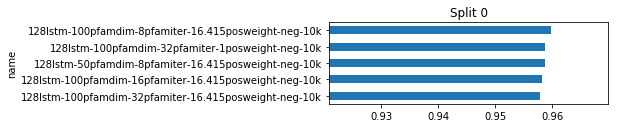

Split 1
Top model based on validation data: 128lstm-0.001lr-100pfamdim-4pfamiter-16.415posweight-neg-10k
Validation AUC: 0.9500271091798457
Test AUC: 0.9500266640022184


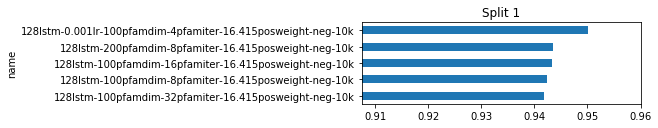

Split 2
Top model based on validation data: 128lstm-100pfamdim-4pfamiter-16.415posweight-neg-10k
Validation AUC: 0.9405005172663782
Test AUC: 0.9497181948753763


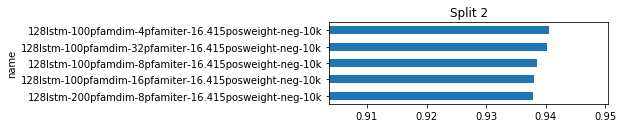

Split 3
Top model based on validation data: 128lstm-200pfamdim-4pfamiter-16.415posweight-neg-10k
Validation AUC: 0.9437942488832484
Test AUC: 0.9389075568463047


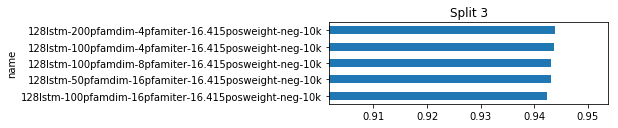

Split 4
Top model based on validation data: 128lstm-100pfamdim-8pfamiter-16.415posweight-neg-10k
Validation AUC: 0.9409516062861115
Test AUC: 0.9519991966656579


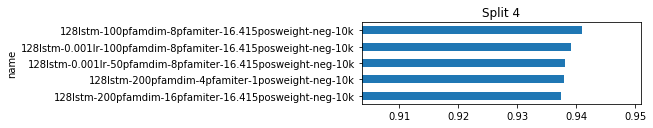

In [140]:
predicted_best = bootstrap_split_results(neg10k_models)


In [155]:
predicted_best.to_csv('../data/clusterfinder/labelled/prediction/lstm_bootstrapped.csv')

Pfam2vec: 0.946 AUC


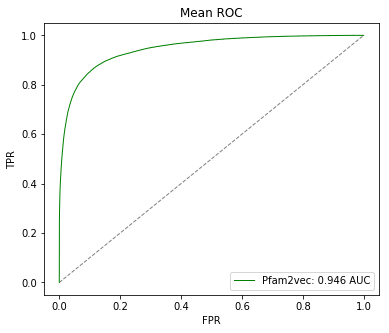

In [142]:
roc_ax = plot_roc_curve(predicted_best['in_cluster'], predicted_best['prediction'], label='Pfam2vec', color='green', title='Mean ROC')

DeepBGC: 0.946 AUC


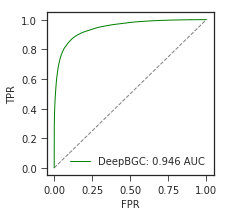

In [168]:
with plt.style.context(('seaborn-ticks')):
    roc_ax = plot_roc_curve(predicted_best['in_cluster'], predicted_best['prediction'], label='DeepBGC', color='green', title='', figsize=(3,3))

# Choosing final parameter configuration

In [143]:
def plot_field_boxplot(models, field, figsize=None, sort=True, metric='test_auc'):
    fig, ax = plt.subplots(figsize=figsize)
    ordering = None
    if sort:
        ordering = models.groupby(field)[metric].median().sort_values(ascending=False).index.values[:20]
    sns.boxplot(x=metric, y=field, orient='h', data=models, color='white', width=0.6, linewidth=1, ax=ax, order=ordering)
    if field != 'name':
        field_values = models[field].unique()
        other_params = list(np.setdiff1d(PARAM_COLS, [field]))
        best = []
        for _, identical_models_except_field in models.set_index(field).groupby(other_params):
            aucs = identical_models_except_field[metric]
            best.append(aucs.idxmax())
        best = pd.DataFrame({'num_best': pd.Series(best).value_counts()})
        best['frac_best'] = best['num_best'] / best['num_best'].sum()
        print(best)

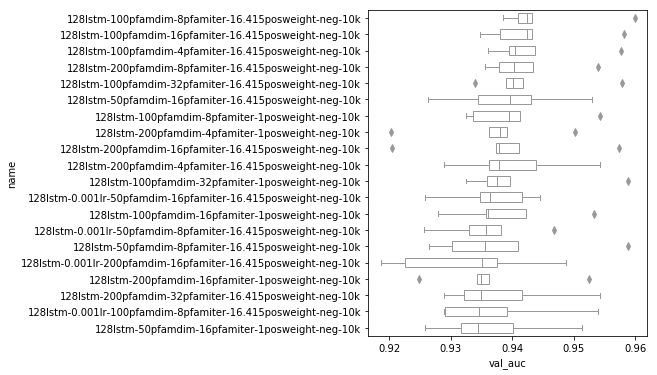

In [144]:
plot_field_boxplot(neg10k_models, 'name', figsize=(5, 6), metric='val_auc')

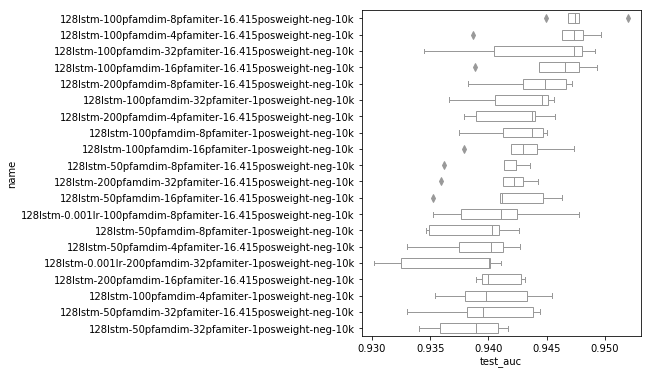

In [145]:
plot_field_boxplot(neg10k_models, 'name', figsize=(5, 6))

         num_best  frac_best
128lstm       240        1.0


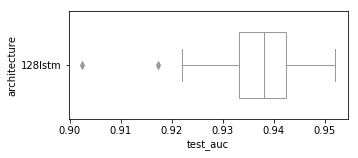

In [146]:
plot_field_boxplot(neg10k_models, 'architecture', figsize=(5, 2), sort=False)

     num_best  frac_best
100        51     0.6375
200        20     0.2500
50          9     0.1125


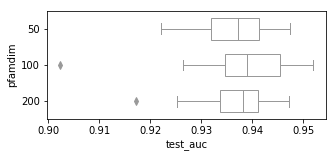

In [147]:
plot_field_boxplot(neg10k_models, 'pfamdim', figsize=(5, 2), sort=False)

          num_best  frac_best
weighted        96        0.8
1               24        0.2


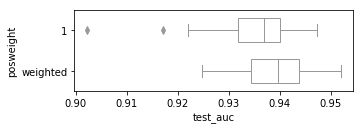

In [148]:
plot_field_boxplot(neg10k_models, 'posweight', figsize=(5, 1.5), sort=False)

    num_best  frac_best
8         21       0.35
32        15       0.25
16        12       0.20
4         12       0.20


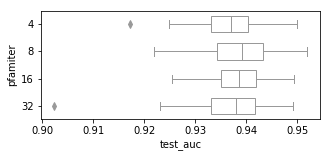

In [149]:
plot_field_boxplot(neg10k_models, 'pfamiter', figsize=(5, 2), sort=False)

        num_best  frac_best
0.0001       104   0.866667
0.0010        16   0.133333


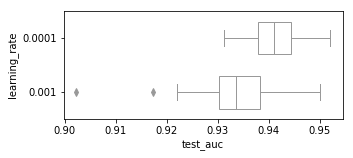

In [150]:
plot_field_boxplot(neg10k_models, 'learning_rate', figsize=(5, 2), sort=False)

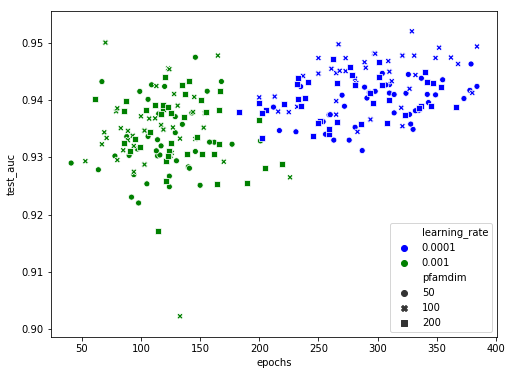

In [151]:
df = neg10k_models.copy()
df['learning_rate'] = df['learning_rate'].astype(str)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax = sns.scatterplot(data=df, x='epochs', y='test_auc', style='pfamdim', hue='learning_rate', ax=ax, palette={'0.001':'green', '0.0001':'blue'})
#ax.axvline(250)

# Optimal parameter model results

In [152]:
def isoptimal(row):
    return row['pfamdim'] == 100 \
        and row['pfamiter'] == 8 \
        and row['architecture'] == '128lstm' \
        and row['posweight'] == 'weighted' \
        and row['learning_rate'] == 0.0001
        
optimal = neg10k_models[neg10k_models.apply(isoptimal, axis=1)]
optimal

,architecture,classbalancing,epochs,features,learning_rate,name,negset,pfamdim,pfamiter,posweight,split,test_auc,val_auc
175,128lstm,,310,,0.0001,128lstm-100pfamdim-8pfamiter-16.415posweight-n...,neg-10k,100,8,weighted,0,0.944951,0.959871
176,128lstm,,331,,0.0001,128lstm-100pfamdim-8pfamiter-16.415posweight-n...,neg-10k,100,8,weighted,1,0.947751,0.942345
177,128lstm,,362,,0.0001,128lstm-100pfamdim-8pfamiter-16.415posweight-n...,neg-10k,100,8,weighted,2,0.947411,0.938563
178,128lstm,,309,,0.0001,128lstm-100pfamdim-8pfamiter-16.415posweight-n...,neg-10k,100,8,weighted,3,0.946805,0.943135
179,128lstm,,329,,0.0001,128lstm-100pfamdim-8pfamiter-16.415posweight-n...,neg-10k,100,8,weighted,4,0.951999,0.940952


In [153]:
round(optimal['epochs'].mean())

328

In [154]:
top_model_name = optimal['name'].unique()[0]
top_model_name

'128lstm-100pfamdim-8pfamiter-16.415posweight-neg-10k'

# Negative set size evaluation

In [8]:
with open(os.path.join(MODELS_DIR, top_model_name, 'config.json')) as f:
    print(f.read())

{
  "type": "KerasRNN",
  "build_params": {
    "batch_size": 64,
    "hidden_size": 32,
    "stateful": true
  },
  "fit_params": {
    "timesteps": 256,
    "validation_size": 0,
    "verbose": 1,
    "num_epochs": 1000,
    "early_stop_monitor": "val_auc_roc",
    "early_stop_min_delta": 0.0005,
    "early_stop_patience": 20,
    "early_stop_mode": "max",
    "gpus": 0,
    "shuffle": true,
    "optimizer": "adam",
    "learning_rate": 0.0001,
    "positive_weight": 16.415
  },
  "input_params": {
    "features": [
      {
        "type": "ProteinBorderTransformer"
      },
      {
        "type": "Pfam2VecTransformer",
        "vector_path": "../../../../features/pfam2vec-experiments/iterations/pfam2vec_corpus-1e-02_skipgram_100dim_5win_8iter.bin"
      }
    ]
  }
}




In [25]:
negmodels = []
missing = 0
total = 0
for pfamdim in [50, 100, 200]:   #50, 100, 200]:#, 300
    for pfamiter in [4, 8, 16, 32]:   #2, , 64, 128
        for negset in ['neg-3k', 'neg-6k','neg-10k']:  #['first-neg', 'neg-3k', 'neg-6k', 'neg-10k', 'neg-10k-rerun', 'neg-10k-seed2']:
            for split in SPLIT_IDS:
                total += 1
                try:
                    args = dict(
                        features='',
                        learning_rate=0.0001,
                        pfamdim=pfamdim,
                        pfamiter=pfamiter,
                        posweight='1',
                        negset=negset,
                        classbalancing='',
                        split=split
                    )
                    summary = get_model_summary(**args)
                    negmodels.append(summary)
                except FileNotFoundError:
                    missing += 1
                    print('No predictions for model: {}'.format(args))
if missing:
    print('Missing {}/{}!'.format(missing, total))
negmodels = pd.DataFrame(negmodels)

         num_best  frac_best
neg-6k         27       0.45
neg-10k        27       0.45
neg-3k          6       0.10


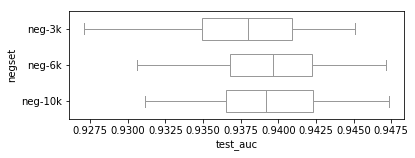

In [26]:
plot_field_boxplot(negmodels, 'negset', figsize=(6, 2), sort=False)

# Re-running with same parameters

In [54]:
rerun = []
missing = 0
total = 0
for pfamiter in [4, 8, 16, 32, 64, 128]:   #2, , 64, 128
    for negset in ['neg-10k', 'neg-10k-rerun']:  #['first-neg', 'neg-3k', 'neg-6k', 'neg-10k', 'neg-10k-rerun', 'neg-10k-seed2']:
        for split in SPLIT_IDS:
            total += 1
            try:
                args = dict(
                    features='',
                    learning_rate=0.0001,
                    pfamdim=100,
                    pfamiter=pfamiter,
                    posweight='1',
                    negset=negset,
                    classbalancing='',
                    split=split
                )
                summary = get_model_summary(**args)
                rerun.append(summary)
            except FileNotFoundError:
                missing += 1
                print('No predictions for model: {}'.format(args))
if missing:
    print('Missing {}/{}!'.format(missing, total))
rerun = pd.DataFrame(rerun)

In [55]:
rerun.head()

,classbalancing,epochs,features,learning_rate,name,negset,pfamdim,pfamiter,posweight,split,test_auc,val_auc
0,,216,,0.0001,128lstm-100pfamdim-4pfamiter-1posweight-neg-10k,neg-10k,100,4,1,0,0.937987,0.952443
1,,261,,0.0001,128lstm-100pfamdim-4pfamiter-1posweight-neg-10k,neg-10k,100,4,1,1,0.945463,0.940560
2,,265,,0.0001,128lstm-100pfamdim-4pfamiter-1posweight-neg-10k,neg-10k,100,4,1,2,0.939818,0.928084
3,,321,,0.0001,128lstm-100pfamdim-4pfamiter-1posweight-neg-10k,neg-10k,100,4,1,3,0.935427,0.934086
4,,312,,0.0001,128lstm-100pfamdim-4pfamiter-1posweight-neg-10k,neg-10k,100,4,1,4,0.943291,0.931974


               num_best  frac_best
neg-10k              16   0.533333
neg-10k-rerun        14   0.466667


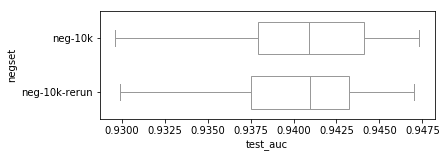

In [56]:
plot_field_boxplot(rerun, 'negset', figsize=(6, 2), sort=False)

In [ ]:
a = rerun[rerun['negset']=='neg-10k'].reset_index()['test_auc']
b = rerun[rerun['negset']=='neg-10k-rerun'].reset_index()['test_auc']

pd.DataFrame({'neg-10k': a, 'neg-10k-rerun': b}).plot()

In [ ]:
a = rerun[rerun['negset']=='neg-10k'].reset_index()['val_auc']
b = rerun[rerun['negset']=='neg-10k-rerun'].reset_index()['val_auc']

pd.DataFrame({'neg-10k': a, 'neg-10k-rerun': b}).plot()

In [ ]:
a = rerun[rerun['negset']=='neg-10k'].reset_index()['epochs']
b = rerun[rerun['negset']=='neg-10k-rerun'].reset_index()['epochs']

pd.DataFrame({'neg-10k': a, 'neg-10k-rerun': b}).plot()

# Random vector LSTM

In [70]:
names = [
    '128lstm-0.001lr-100random-16.415posweight-neg-10k',
    '128lstm-0.001lr-100random-1posweight-neg-10k',
    '128lstm-100random-16.415posweight-neg-10k',
    '128lstm-100random-1posweight-neg-10k'
]
random_models = []
for name in names:
    for split in SPLIT_IDS:
        random_models.append({
            'split': split,
            'name': name,
            'epochs': get_model_split_num_epochs(name, split=split),
            'val_auc': get_model_split_auc(name, split=split, method='validation'),
            'test_auc': get_model_split_auc(name, split=split, method='test')
        })
random_models = pd.DataFrame(random_models)
random_models

,epochs,name,split,test_auc,val_auc
0,216,128lstm-0.001lr-100random-16.415posweight-neg-10k,0,0.907771,0.918503
1,400,128lstm-0.001lr-100random-16.415posweight-neg-10k,1,0.902949,0.908750
2,324,128lstm-0.001lr-100random-16.415posweight-neg-10k,2,0.902539,0.902819
3,400,128lstm-0.001lr-100random-16.415posweight-neg-10k,3,0.902491,0.902247
4,400,128lstm-0.001lr-100random-16.415posweight-neg-10k,4,0.903176,0.889754
5,400,128lstm-0.001lr-100random-1posweight-neg-10k,0,0.896821,0.922427
6,170,128lstm-0.001lr-100random-1posweight-neg-10k,1,0.914797,0.908546
7,196,128lstm-0.001lr-100random-1posweight-neg-10k,2,0.914459,0.911862
8,400,128lstm-0.001lr-100random-1posweight-neg-10k,3,0.912853,0.880359
9,400,128lstm-0.001lr-100random-1posweight-neg-10k,4,0.920493,0.909522


In [72]:
random_val_best = random_models.groupby('name')['val_auc'].idxmax()
random_val_best

name
128lstm-0.001lr-100random-16.415posweight-neg-10k     0
128lstm-0.001lr-100random-1posweight-neg-10k          5
128lstm-100random-16.415posweight-neg-10k            10
128lstm-100random-1posweight-neg-10k                 17
Name: val_auc, dtype: int64

In [74]:
random_results = random_models.loc[random_val_best][['val_auc','test_auc']]
print('Mean random AUC: {}'.format(random_results.mean()))
random_results

Mean random AUC: val_auc     0.922884
test_auc    0.897372
dtype: float64


,val_auc,test_auc
0,0.918503,0.907771
5,0.922427,0.896821
10,0.924009,0.866244
17,0.926598,0.918651


# Training progress

In [98]:
def plot_model_training_progress(output_path):
    metrics = []
    with open(output_path) as f:
        epoch = 0
        for line in f.readlines():
            if line.startswith(' - ') and 'loss' in line:
                epoch += 1
                tokens = line.split(' - ')
                values = {token.split(':')[0]: float(token.split(':')[1]) for token in tokens if ':' in token}
                values['epoch'] = epoch
                metrics.append(values)
    metrics = pd.DataFrame(metrics).set_index('epoch')
    fig, axes = plt.subplots(3, figsize=(10, 8))
    metrics[['auc_roc','val_auc_roc']].plot(ax=axes[0], title='model0')
    metrics[['recall','val_recall']].plot(ax=axes[1])
    metrics[['precision','val_precision']].plot(ax=axes[2])
    return metrics

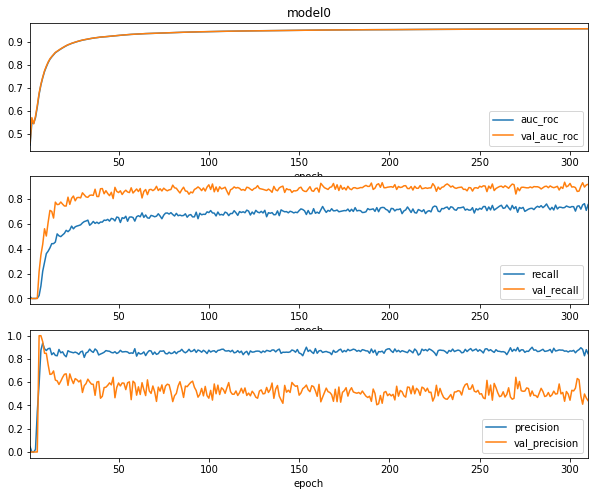

In [166]:
model_path = '../data/evaluation/labelled-bootstrap/models/128lstm-100pfamdim-8pfamiter-16.415posweight-neg-10k/model0.out'
plot_model_training_progress(model_path);

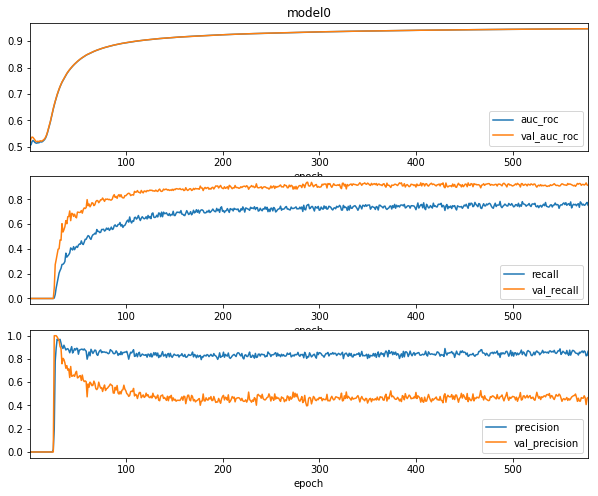

In [99]:
model_path = '../data/evaluation/labelled-bootstrap/models/32lstm8full-100pfamdim-8pfamiter-16.415posweight-neg-10k/model1.out'
plot_model_training_progress(model_path);

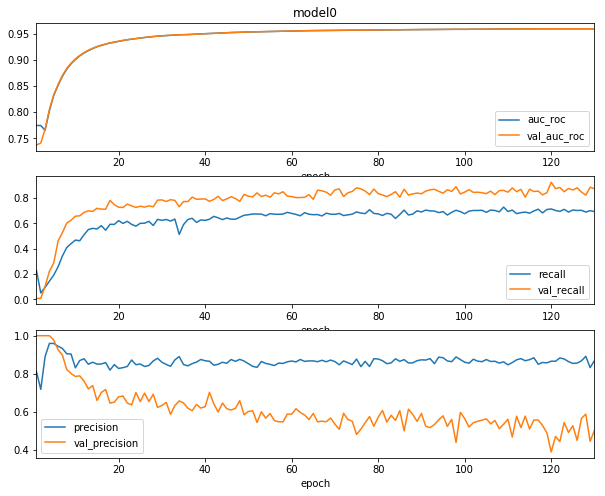

In [174]:
model_path = '../data/evaluation/labelled-bootstrap/models/posprob_128lstm-100pfamdim-8pfamiter-16.415posweight-neg-10k/model3.out'
plot_model_training_progress(model_path);